These are some fairly rough notes and code snippets highlighting different aspects of the Hawken et al. draft paper 'Constraints on the growth of structure around cosmic voids in eBOSS' (version May 2019)

In [1]:
from __future__ import print_function
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import quad
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
from scipy.special import hyp2f1

rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('axes', linewidth=1.3)
rc('font', **{'weight':'bold'})

# Preliminaries

I'll focus only on the LRG data. To demonstrate things, I've scraped data on monopole $\xi_0$ and quadrupole $\xi_2$ from the figures in the paper: this is obviously not completely accurate but it is good enough to make the point.

In [2]:
r_bins = np.array([0.125, 0.375, 0.625, 0.875, 1.125, 1.375, 1.625, 1.875, 2.125, 
                   2.375, 2.625, 2.875, 3.125, 3.375])
mock_mdata = np.array([-0.43073, -0.41565, -0.13623, 0.18632, 0.24313, 0.15664, 0.054840, 0.0031289, 
                       -0.020759, -0.022378, -0.021219, -0.022846, -0.020294, -0.017742])
mdata = np.array([-0.49472, -0.45740, -0.12093, 0.17101, 0.21948, 0.13020, 0.038142, -0.0080063, 
                  -0.023541, -0.025163, -0.021219, -0.013105, -0.010555, -0.019136])

mock_qdata = np.array([0.028218, 0.04361, 0.079174, 0.090391, 0.048738, 0.0022186, -0.021346, 
                       -0.024737, -0.026043, -0.021626, -0.015435, -0.01326, -0.0096955, -0.008217 ])
qdata = np.array([-0.038272, 0.13203, 0.042679, 0.058634, 0.097669, 0.021303, 0.0026377, -0.033339, 
                  0.012910, -0.014411, 0.017409, -0.0012556, -0.0026105, 0.00036025])

# build interpolating functions for later use
mock_xi = InterpolatedUnivariateSpline(r_bins, mock_mdata, k=1)
integral = np.zeros_like(r_bins)
for i in range(len(integral)):
    integral[i] = quad(lambda x: mock_xi(x) * x ** 2, 0, r_bins[i], full_output=1)[0]
mock_xibar = InterpolatedUnivariateSpline(r_bins, 3 * integral / r_bins ** 3, k=1)

xi = InterpolatedUnivariateSpline(r_bins, mdata, k=1)
for i in range(len(integral)):
    integral[i] = quad(lambda x: xi(x) * x ** 2, 0, r_bins[i], full_output=1)[0]
xibar = InterpolatedUnivariateSpline(r_bins, 3 * integral / r_bins ** 3, k=1)

r = np.linspace(0, 3.5)

I also scraped data on the error bars on $\xi_2$, but for now ignored any errors on $\xi_0$ since these are much smaller

In [3]:
hlerrs = np.array([[-0.18256, 0.10891], [0.069348, 0.19804], [-0.014044, 0.097261], [0.010389, 0.11126],
                   [0.061957, 0.13917], [-0.011695, 0.055087], [-0.022739, 0.028044], [-0.056740, -0.0087401],
                   [-0.0093468, 0.035870], [-0.036391, 0.0060438], [-0.0036090, 0.036043], 
                   [-0.018131, 0.018738], [-0.020129, 0.013958], [-0.013782, 0.018218]])
qerr = 0.5 * (hlerrs[:, 1] - hlerrs[:, 0])
mock_qerr = qerr / np.sqrt(499.)

Just check that this looks approximately like it should (small differences to the true data won't be massively important):

(-0.3, 0.4)

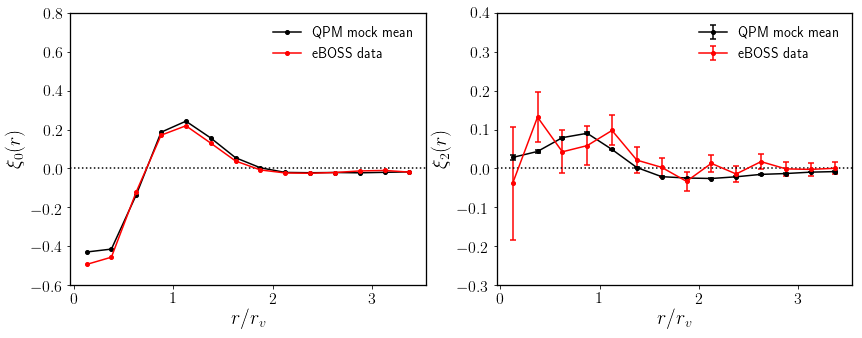

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes.flat[0]
ax.errorbar(r_bins, mock_mdata, fmt='.-', c='k', markersize=8, 
             elinewidth=1.5, capsize=3, capthick=1.5, label='QPM mock mean')
ax.errorbar(r_bins, mdata, fmt='.-', c='r', markersize=8, 
             elinewidth=1.5, capsize=3, capthick=1.5, label='eBOSS data')
ax.axhline(0, ls=':', c='k')
ax.legend(loc='upper right', numpoints=1, frameon=False, fontsize=14)
ax.tick_params(labelsize=16)
ax.set_xlabel('$r/r_v$', fontsize=20)
ax.set_ylabel('$\\xi_0(r)$', fontsize=20)
ax.set_ylim([-0.6, 0.8])

ax = axes.flat[1]
ax.errorbar(r_bins, mock_qdata, yerr=mock_qerr, fmt='.-', c='k', markersize=8, 
             elinewidth=1.5, capsize=3, capthick=1.5, label='QPM mock mean')
ax.errorbar(r_bins, qdata, yerr=qerr, fmt='.-', c='r', markersize=8, 
             elinewidth=1.5, capsize=3, capthick=1.5, label='eBOSS data')
ax.axhline(0, ls=':', c='k')
ax.legend(loc='upper right', numpoints=1, frameon=False, fontsize=14)
ax.tick_params(labelsize=16)
ax.set_xlabel('$r/r_v$', fontsize=20)
ax.set_ylabel('$\\xi_2(r)$', fontsize=20)
ax.set_ylim([-0.3, 0.4])

# 1. Sections 4.1 and 4.3

## 1.1. Assumption of stationary void centres

This is a crucial assumption! See long discussion in https://arxiv.org/abs/1805.09349. How do we know if it is justified?

To be clear: this assumption is definitely invalid for simulation data, as shown in the paper above, and is also invalid for BOSS voids. It is possible that although the assumption is wrong, the estimator in this paper is still unbiased (by coincidence). But this should be demonstrated using tests on the mocks, where the cosmology is known! See further discussion below.

## 1.2. Theory approximations

The theory model in Section 4.1 is based on a series expansion which keeps terms of order $\xi_0(r)$ and $\bar\xi(r)$ but drops terms of order $\xi_0(r)^2$ and $\xi_0(r)\bar\xi(r)$ (see https://arxiv.org/abs/1712.07575 Section III and https://arxiv.org/abs/1904.01030 Section IVa for detailed derivation). 

**Is this approximation justified?**

In Section 4.3 it is argued that corrections to the model are only required for voids with 'deep centres', and so aren't important for the eBOSS voids which are shallow. But here's a plot showing the relative sizes of the terms *for the eBOSS LRG void data in this paper*:

Text(0,0.5,'series expansion terms')

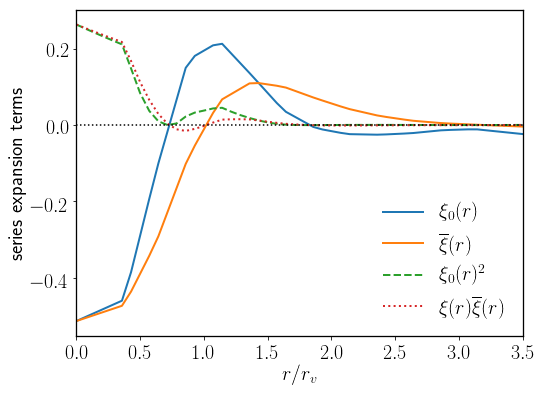

In [5]:
plt.figure(figsize=(8,6))
plt.plot(r, xi(r), lw=2, label=r'$\xi_0(r)$')
plt.plot(r, xibar(r), lw=2, label=r'$\overline{\xi}(r)$')
plt.plot(r, xi(r) * xi(r), lw=2, ls='--', label=r'$\xi_0(r)^2$')
plt.plot(r, xi(r) * xibar(r), lw=2, ls=':', label=r'$\xi(r)\overline{\xi}(r)$')
plt.axhline(0, ls=':', c='k')
plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=20)
plt.tick_params(labelsize=20)
plt.xlabel('$r/r_v$', fontsize=20)
plt.xlim([0, 3.5])
plt.ylabel('series expansion terms', fontsize=20)


Clearly the neglected terms are substantial at $r<0.5r_v$ even for these eBOSS voids ($\xi_0(r)^2$ is also not negligible at $r\sim r_v$). So the argument about 'deep centres' isn't really valid. 

**What difference does this make to the theory model?**

Equations 4.8 and 4.9 in the draft are only approximate. Better approximations including the neglected terms are given in https://arxiv.org/abs/1712.07575:

$\xi_0^s(r) = \xi_0^r(r) + \frac{\beta}{3}\xi_0^r(r) + \frac{\beta}{9}r\xi_0^{r\prime}(r)\xi_0^r(r) + \frac{\beta}{3}\xi_0^r(r)^2$

and 

$\xi_2^s(r) = \frac{2\beta}{3}\left(\xi_0^r(r) - \overline{\xi}(r)\right) + \frac{2\beta}{3}\left(\xi_0^r(r) - \overline{\xi}(r)\right)\xi_0^r(r) + \frac{2\beta}{9}r\xi_0^{r\prime}(r)\overline{\xi}(r)$

where superscript $^r$ denotes quantities in real space, $^s$ denotes quantities in redshift space, and the $^{\prime}$ denotes a derivative with respect to $r$.

The correct equations above are based on the ***identical*** model, with ***identical*** physical assumptions, namely:

- velocity field is given by linear theory only (i.e. 'strictly linear' as in the draft)
- no velocity dispersion
- scale-independent linear bias assumption holds within voids, $\xi_0^r(r) = b\delta(r)$ where $b=2.3$ is the LRG bias
- void centres assumed stationary

The ***only*** change is that more terms have been retained in the series expansion.

This has 2 important consequences:

1. The monopole-to-quadrupole ratio estimator is only approximate
2. The correct model calculation requires $\xi_0^r(r)$, which is *a priori* unknown

**How big a difference does this make?**

To estimate the effect on the quadrupole, let's assume $\xi_0^r(r) = \frac{3}{3+\beta}\xi_0^s(r)$ and use the measured data from above (obviously this isn't completely correct, but it gives us a good sense of the size of the errors in $\xi_2^s(r)$). Then: 

Text(0,0.5,'$\\xi_2(r)$')

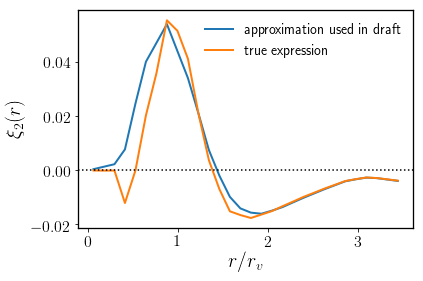

In [6]:
def approximate_model_quadrupole(beta, xi_s, xibar_s, s):
    
    q = 2 * beta * (xi_s(s) - xibar_s(s)) / (3 + beta)
    return q


def better_model_quadrupole(beta, xi_s, xibar_s, s, mu):

    fac = 3. / (3 + beta)
    r = s * (1 + (beta * fac * xibar_s(s) / 3.) * mu**2.)
    model = fac * xi_s(r) + beta * fac * xibar_s(r) * (1 + fac * xi_s(r)) / 3. + \
            beta * fac * (xi_s(r) - xibar_s(r)) * (1 + fac * xi_s(r)) * mu**2. 

    rv = s[0,:] 
    Mu = mu[:,0] 
    output = np.zeros(len(rv))
    for i in range(len(rv)):
        mufunc = InterpolatedUnivariateSpline(Mu, model[:,i], k=3)
        output[i] = quad(lambda x: mufunc(x) * 5 * (3 * x**2 - 1) / 2., 0, 1)[0]
    return output


r = np.linspace(0, 3.5, 31)
rmid = 0.5 * (r[1:] + r[:-1])
mu = np.linspace(0, 1, 101)
mumid = 0.5 * (mu[1:] + mu[:-1])
S, Mu = np.meshgrid(rmid, mumid)

beta = 0.354 # fiducial cosmology value for LRGs

approx_quad = approximate_model_quadrupole(beta, xi, xibar, rmid)
better_quad = better_model_quadrupole(beta, xi, xibar, S, Mu)

plt.plot(rmid, approx_quad, lw=2, label='approximation used in draft')
plt.plot(rmid, better_quad, lw=2, label='true expression')
plt.axhline(0, ls=':', c='k')
plt.legend(loc='upper right', numpoints=1, frameon=False, fontsize=14)
plt.tick_params(labelsize=16)
plt.xlabel('$r/r_v$', fontsize=20)
plt.ylabel('$\\xi_2(r)$', fontsize=20)


The difference is clear, but might not be distinguishable with current eBOSS DR14 data, as the statistical errors in the measured quadrupole are very large at $r<r_v$. This could be a reasonable argument to use instead of the 'deep centres' one.

# 2. Systematic errors

The combination of problems in 1.1 and 1.2 above can lead to biased estimates of the growth rate. Appendix A in https://arxiv.org/abs/1805.09349 shows this for simulations with a known cosmology: the systematic error in $\beta$ is large, and can be much bigger than the statistical error.

To assess possible systematics, it is not valid to argue that the $\beta$ recovered from the eBOSS *data* matches $\Lambda$CDM! Instead you need to show this by tests on mocks with a known cosmology. 

To demonstrate, here's a plot of the measured QPM mock mean quadrupole $\xi_2(r)$ vs. the prediction from applying the model used in the paper to the QPM mock mean monopole and using the fiducial value of $\beta=0.354$ for eBOSS LRGs:

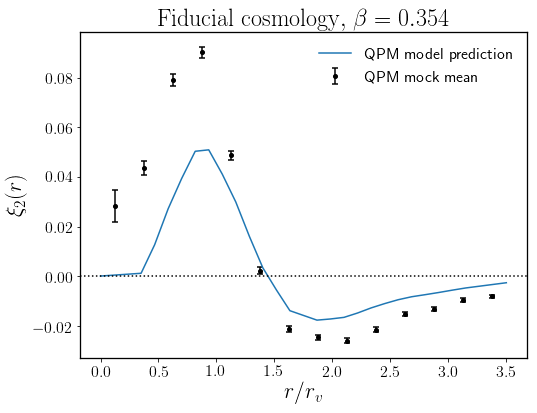

In [7]:
plt.figure(figsize=(8,6))
plt.errorbar(r_bins, mock_qdata, yerr=mock_qerr, fmt='.', c='k', markersize=8, 
             elinewidth=1.5, capsize=3, capthick=1.5, label='QPM mock mean')
plt.plot(r, 2 * beta * (mock_xi(r) - mock_xibar(r)) / (3 + beta), label='QPM model prediction')
plt.axhline(0, ls=':', c='k')
plt.legend(loc='upper right', numpoints=1, frameon=False, fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel(r'$r/r_v$', fontsize=22)
plt.ylabel(r'$\xi_2(r)$', fontsize=22)
plt.title(r'$\mathrm{Fiducial\;cosmology,\;}\beta=%0.3f$' % beta, fontsize=24);

Clearly the model does not describe the mocks well!

We can see this more explicitly by doing a rough fit for $\beta$ and we get a value that is very different to the fiducial (this is only approximate, but even by eye you can see $\beta\sim0.65$ provides a better fit to the data):

Approximate best-fit to mocks:
	beta = 0.629+0.004-0.009
Minimum chi-squared = 426.724


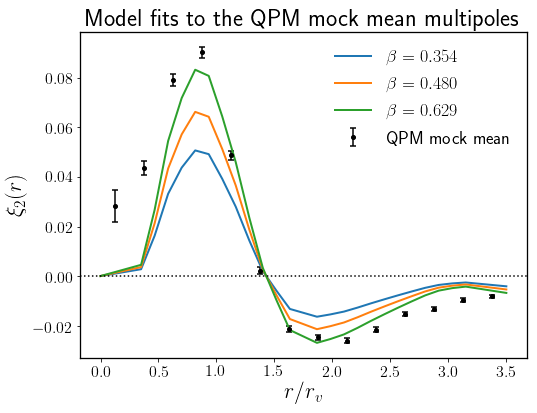

In [8]:
plt.figure(figsize=(8,6))
plt.errorbar(r_bins, mock_qdata, yerr=mock_qerr, fmt='.', c='k', markersize=8, 
             elinewidth=1.5, capsize=3, capthick=1.5, label='QPM mock mean')

beta = 0.354  # fiducial beta value for LRGs
factor = 2 * beta / (3 + beta)
G = np.linspace(0.1 * factor, 3 * factor, 300)
mock_chi2 = np.zeros_like(G)
chi2 = np.zeros_like(G)

# simplistically assume the covariance matrix is diagonal
icov = np.linalg.inv(np.diag(qerr**2))
mock_icov = np.linalg.inv(np.diag(mock_qerr**2))
for i, g in enumerate(G):
    theory = g * (mock_xi(r_bins) - mock_xibar(r_bins))
    mock_chi2[i] = np.dot(np.dot((theory - mock_qdata), mock_icov), theory - mock_qdata)
    theory = g * (xi(r_bins) - xibar(r_bins))
    chi2[i] = np.dot(np.dot((theory - qdata), icov), theory - qdata)

print("Approximate best-fit to mocks:")
best_mock_beta = 3 * G[np.argmin(mock_chi2)] / (2 - G[np.argmin(mock_chi2)])
mock_betaminus = (3*G / (2-G))[np.where(mock_chi2-np.min(mock_chi2)<=1)[0][0]]
mock_betaplus = (3*G / (2-G))[np.where(mock_chi2-np.min(mock_chi2)<=1)[0][-1]]
print("\tbeta = %0.3f+%0.3f-%0.3f" % (best_mock_beta, mock_betaplus - best_mock_beta, best_mock_beta - mock_betaminus))
print('Minimum chi-squared = %0.3f' % np.min(mock_chi2))

plt.plot(r, 2 * beta * (xi(r) - xibar(r)) / (3 + beta), lw=2, label=r'$\beta=%0.3f$' % beta)
beta_data = 0.48
plt.plot(r, 2 * beta_data * (xi(r) - xibar(r)) / (3 + beta_data), lw=2, label=r'$\beta=%0.3f$' % beta_data)
plt.plot(r, 2 * best_mock_beta * (xi(r) - xibar(r)) / (3 + best_mock_beta), lw=2, label=r'$\beta=%0.3f$' % best_mock_beta)
# beta = best_beta
# plt.plot(x, 2 * beta * (xi(x) - xibar(x)) / (3 + beta), label=r'$\beta=%0.3f$' % beta)
plt.axhline(0, ls=':', c='k')
plt.legend(loc='upper right', numpoints=1, frameon=False, fontsize=18)
plt.tick_params(labelsize=16)
plt.xlabel(r'$r/r_v$', fontsize=22)
plt.ylabel(r'$\xi_2(r)$', fontsize=22)
plt.title('Model fits to the QPM mock mean multipoles', fontsize=24);

## What is the fiducial cosmology?

Some of the numbers in the draft look a bit off to me. The fiducial cosmology used is not specified (!), but I'll assume it is flat $\Lambda$CDM, with $\Omega_M=0.31$ and $\sigma_8(z=0)=0.82$, as this must be pretty close. Based on this and the redshifts and bias values quoted in Table 5, this is what I make the fiducial values to be:

In [9]:
om_m = 0.31
s80 = 0.82
omega_l = 1. - om_m

bias_lrg = 2.30
eff_z_lrg = 0.703
bias_qso = 2.45
eff_z_qso = 1.53

az_lrg = 1. / (1 + eff_z_lrg)
f_lrg = ((om_m * (1 + eff_z_lrg)**3.) / (om_m * (1 + eff_z_lrg)**3 + omega_l))**0.55
growth_lrg = az_lrg ** 2.5 * np.sqrt(omega_l + om_m * az_lrg ** (-3.)) * \
              hyp2f1(5. / 6, 3. / 2, 11. / 6, -(omega_l * az_lrg ** 3.) / om_m) / \
              hyp2f1(5. / 6, 3. / 2, 11. / 6, -omega_l / om_m)
az_qso = 1. / (1 + eff_z_qso)
f_qso = ((om_m * (1 + eff_z_qso)**3.) / (om_m * (1 + eff_z_qso)**3 + omega_l))**0.55
growth_qso = az_qso ** 2.5 * np.sqrt(omega_l + om_m * az_qso ** (-3.)) * \
              hyp2f1(5. / 6, 3. / 2, 11. / 6, -(omega_l * az_qso ** 3.) / om_m) / \
              hyp2f1(5. / 6, 3. / 2, 11. / 6, -omega_l / om_m)

print('fiducial values for LRGs:')
print('\tf = %0.3f' % f_lrg)
print('\tbeta = %0.3f' % (f_lrg / bias_lrg))
print('\tfs8 = %0.3f' % (f_lrg * s80 * growth_lrg))

print('fiducial values for QSOs:')
print('\tf = %0.3f' % f_qso)
print('\tbeta = %0.3f' % (f_qso / bias_qso))
print('\tfs8 = %0.3f' % (f_qso * s80 * growth_qso))



fiducial values for LRGs:
	f = 0.815
	beta = 0.354
	fs8 = 0.466
fiducial values for QSOs:
	f = 0.932
	beta = 0.380
	fs8 = 0.376


Compared to the fiducial values quoted in the paper, $(f\sigma_8)_\mathrm{LRG}=0.57$, and $(f\sigma_8)_\mathrm{QSO}=0.37$ (page 16), it seems something is wrong with the LRG value ...